In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/vantuan_ngo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [116]:
import importlib
import utils
importlib.reload(utils)
from utils import *
import AD
importlib.reload(AD)
from AD import *
import utils_dataset
importlib.reload(utils_dataset)
from utils_dataset import *

In [18]:
# latent_dim = 2^10
# ae = AE(input_channels=2, latent_dim=latent_dim, img_height=300, img_width=14).to(device)
# latent_dim = 512
# ae = AE(latent_dim=latent_dim).to(device)
ae = AE().to(device)
# print(ae.summary())

Output shape verified: torch.Size([2, 300, 14])


In [66]:
import os
import pandas as pd
TRAIN_DF_FILE_PATH = os.path.join("../datasets/FccIQ/synthetic/train_df.csv")
print("TRAIN_DF_FILE_PATH: ", TRAIN_DF_FILE_PATH)
train_df = pd.read_csv(TRAIN_DF_FILE_PATH)
print(f'train_df.shape: {train_df.shape}')
print(train_df.head())

train_df = train_df[train_df["SNR"] == 2]
# train_df = train_df.sample(n=10, random_state=42)

trains = load_train_dataset(train_df)
print(f'trains.shape: {trains.shape}')

TRAIN_DF_FILE_PATH:  ../datasets/FccIQ/synthetic/train_df.csv
train_df.shape: (9844, 7)
   SNR  SIR  MCS  FRQ  Slot  \
0    1   -1    1   -1     1   
1    1   -1    1   -1     2   
2    1   -1    1   -1     4   
3    1   -1    1   -1     5   
4    1   -1    1   -1     6   

                                           file_path  ground_truth_file_path  
0  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
1  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
2  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
3  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
4  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
trains.shape: torch.Size([341, 2, 300, 14])


In [65]:
batch_size = 128
train_loader = DataLoader(trains, batch_size=batch_size, shuffle=True)
i, data = next(enumerate(train_loader))
print(i)
print(data.shape)
print(len(train_loader.dataset))

0
torch.Size([128, 2, 300, 14])
341


In [123]:
epochs = 5000
beta = 100
train_VAE(ae, train_loader, epochs=epochs, learning_rate=1e-5, beta=beta, device=device)
# train_AE(ae, train_loader, epochs=epochs, learning_rate=1e-4, beta=beta, device=device)
# train_autoencoder(ae, train_loader, epochs=epochs)
# train_autoencoder(ae, train_loader, num_epochs=epochs, lr=1e-3, device=device)

Epoch 1/5000, Loss: 33.543577
Epoch 2/5000, Loss: 36.855024
Epoch 3/5000, Loss: 7.580297
Epoch 4/5000, Loss: 22.032821
Epoch 5/5000, Loss: 4.696807
Epoch 6/5000, Loss: 12.373956
Epoch 7/5000, Loss: 2.725772
Epoch 8/5000, Loss: 7.069015
Epoch 9/5000, Loss: 1.952667
Epoch 10/5000, Loss: 3.958817
Epoch 11/5000, Loss: 1.448714
Epoch 12/5000, Loss: 1.974027
Epoch 13/5000, Loss: 1.291198
Epoch 14/5000, Loss: 1.004764
Epoch 15/5000, Loss: 1.067443
Epoch 16/5000, Loss: 0.486556
Epoch 17/5000, Loss: 0.802728
Epoch 18/5000, Loss: 0.411149
Epoch 19/5000, Loss: 0.477616
Epoch 20/5000, Loss: 0.434748
Epoch 21/5000, Loss: 0.328510
Epoch 22/5000, Loss: 0.379230
Epoch 23/5000, Loss: 0.301642
Epoch 24/5000, Loss: 0.286018
Epoch 25/5000, Loss: 0.300436
Epoch 26/5000, Loss: 0.264951
Epoch 27/5000, Loss: 0.255645
Epoch 28/5000, Loss: 0.265682
Epoch 29/5000, Loss: 0.250420
Epoch 30/5000, Loss: 0.252321
Epoch 31/5000, Loss: 0.252241
Epoch 32/5000, Loss: 0.248777
Epoch 33/5000, Loss: 0.255578


KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Image
from io import BytesIO

# Initialize PDF
pdf_filename = "anomaly_maps.pdf"
pdf = SimpleDocTemplate(pdf_filename, pagesize=letter)
elements = []

for batch_idx, iqs in enumerate(train_loader):
    print(f"Processing batch {batch_idx}/{len(train_loader)}")
    print(iqs.shape)
    iqs = iqs.to(device)
    
    with torch.no_grad():
        recons, _ = ae(iqs)
        # print("mu: ", mu)
        # print("logvar: ", logvar)
        # recons = torch.zeros_like(recons)
        # recons = ae(iqs)
        # print(f'recons.shape: {recons.shape}')
        # print(f'iqs.shape: {iqs.shape}')
        anomaly_maps = generate_anomaly_map(iqs, recons)
        
        mses = torch.nn.functional.mse_loss(iqs, recons, reduction='none')
        mses = torch.mean(mses, dim=(1, 2, 3))  # Average across all dimensions except batch
        mses = mses.cpu().numpy()
        print("mse: ", mses)

        print("Saving to file...")
        iqs = iqs.cpu().numpy()
        for i in range(iqs.shape[0]):
            iq = iqs[i]
            recon = recons[i].cpu().numpy()
            anomaly_map = anomaly_maps[i].cpu().numpy().squeeze()
            anomaly_score = np.percentile(anomaly_map, 95)
            # print("iq.shape: ", iq.shape)
            # print("recon.shape: ", recon.shape)
            # print("anomaly_map.shape: ", anomaly_map.shape)
            
            from matplotlib import pyplot as plt
            plt = plot_iq_recon(plt, iq, recon, anomaly_map, mses[i], anomaly_score)

            # Save plot to BytesIO buffer
            bio = BytesIO()
            plt.savefig(bio, format='png', bbox_inches='tight')
            bio.seek(0)
            
            # Add to PDF
            plot_image = Image(bio, width=300, height=300)
            elements.append(plot_image)
            
            plt.close()
            break
        break
    break

print("Building PDF")
pdf.build(elements)
print(f"Saved anomaly plots to ./{pdf_filename}")

In [ ]:
# Determine anomaly threshold
ae.eval()
recon_errors = []
with torch.no_grad():
    for data in train_loader:
        data = data.to(device)
        recon, _ = ae(data)
        error = nn.functional.mse_loss(recon, data, reduction='none')
        # print(error.shape)
        error = torch.sum(error, dim=(1))
        # print(error.shape)
        errors = error.cpu().numpy()
        for error in errors:
            error = np.percentile(error, 95)
            # print(error.shape)
            recon_errors.append(error)

recon_errors = np.array(recon_errors)
print(f"recon_errors.shape: {recon_errors.shape}")
threshold = np.percentile(recon_errors, 95)
print(f"Anomaly Threshold (95th percentile): {threshold:.6f}")

In [ ]:
import os
from datetime import datetime

MODEL_DIR = './models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

model_file_name = f"ae_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}.pth"
model_file_path = os.path.join(MODEL_DIR, model_file_name)

# Optionally, save the entire model (including architecture)
torch.save(ae, model_file_path)
print(f"Full model saved to {model_file_path}")

# Create a softlink to the latest model
import os

# Create softlink to the latest model
latest_model_link = os.path.join(MODEL_DIR, 'ae_latest.pth')
print(f"Latest model link: {latest_model_link}")
if os.path.lexists(latest_model_link):
    print(f"Removing existing link: {latest_model_link}")
    os.remove(latest_model_link)  # Remove existing link if it exists

os.symlink(os.path.join("./", model_file_name), latest_model_link)
print(f"Softlink created: {latest_model_link} -> {model_file_path}")


Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.009474
loss:  tensor(0.7539, device='cuda:0')
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: -0.715280
Recon max: 0.621552
anomaly_map.shape: (300, 14)
(300, 14)


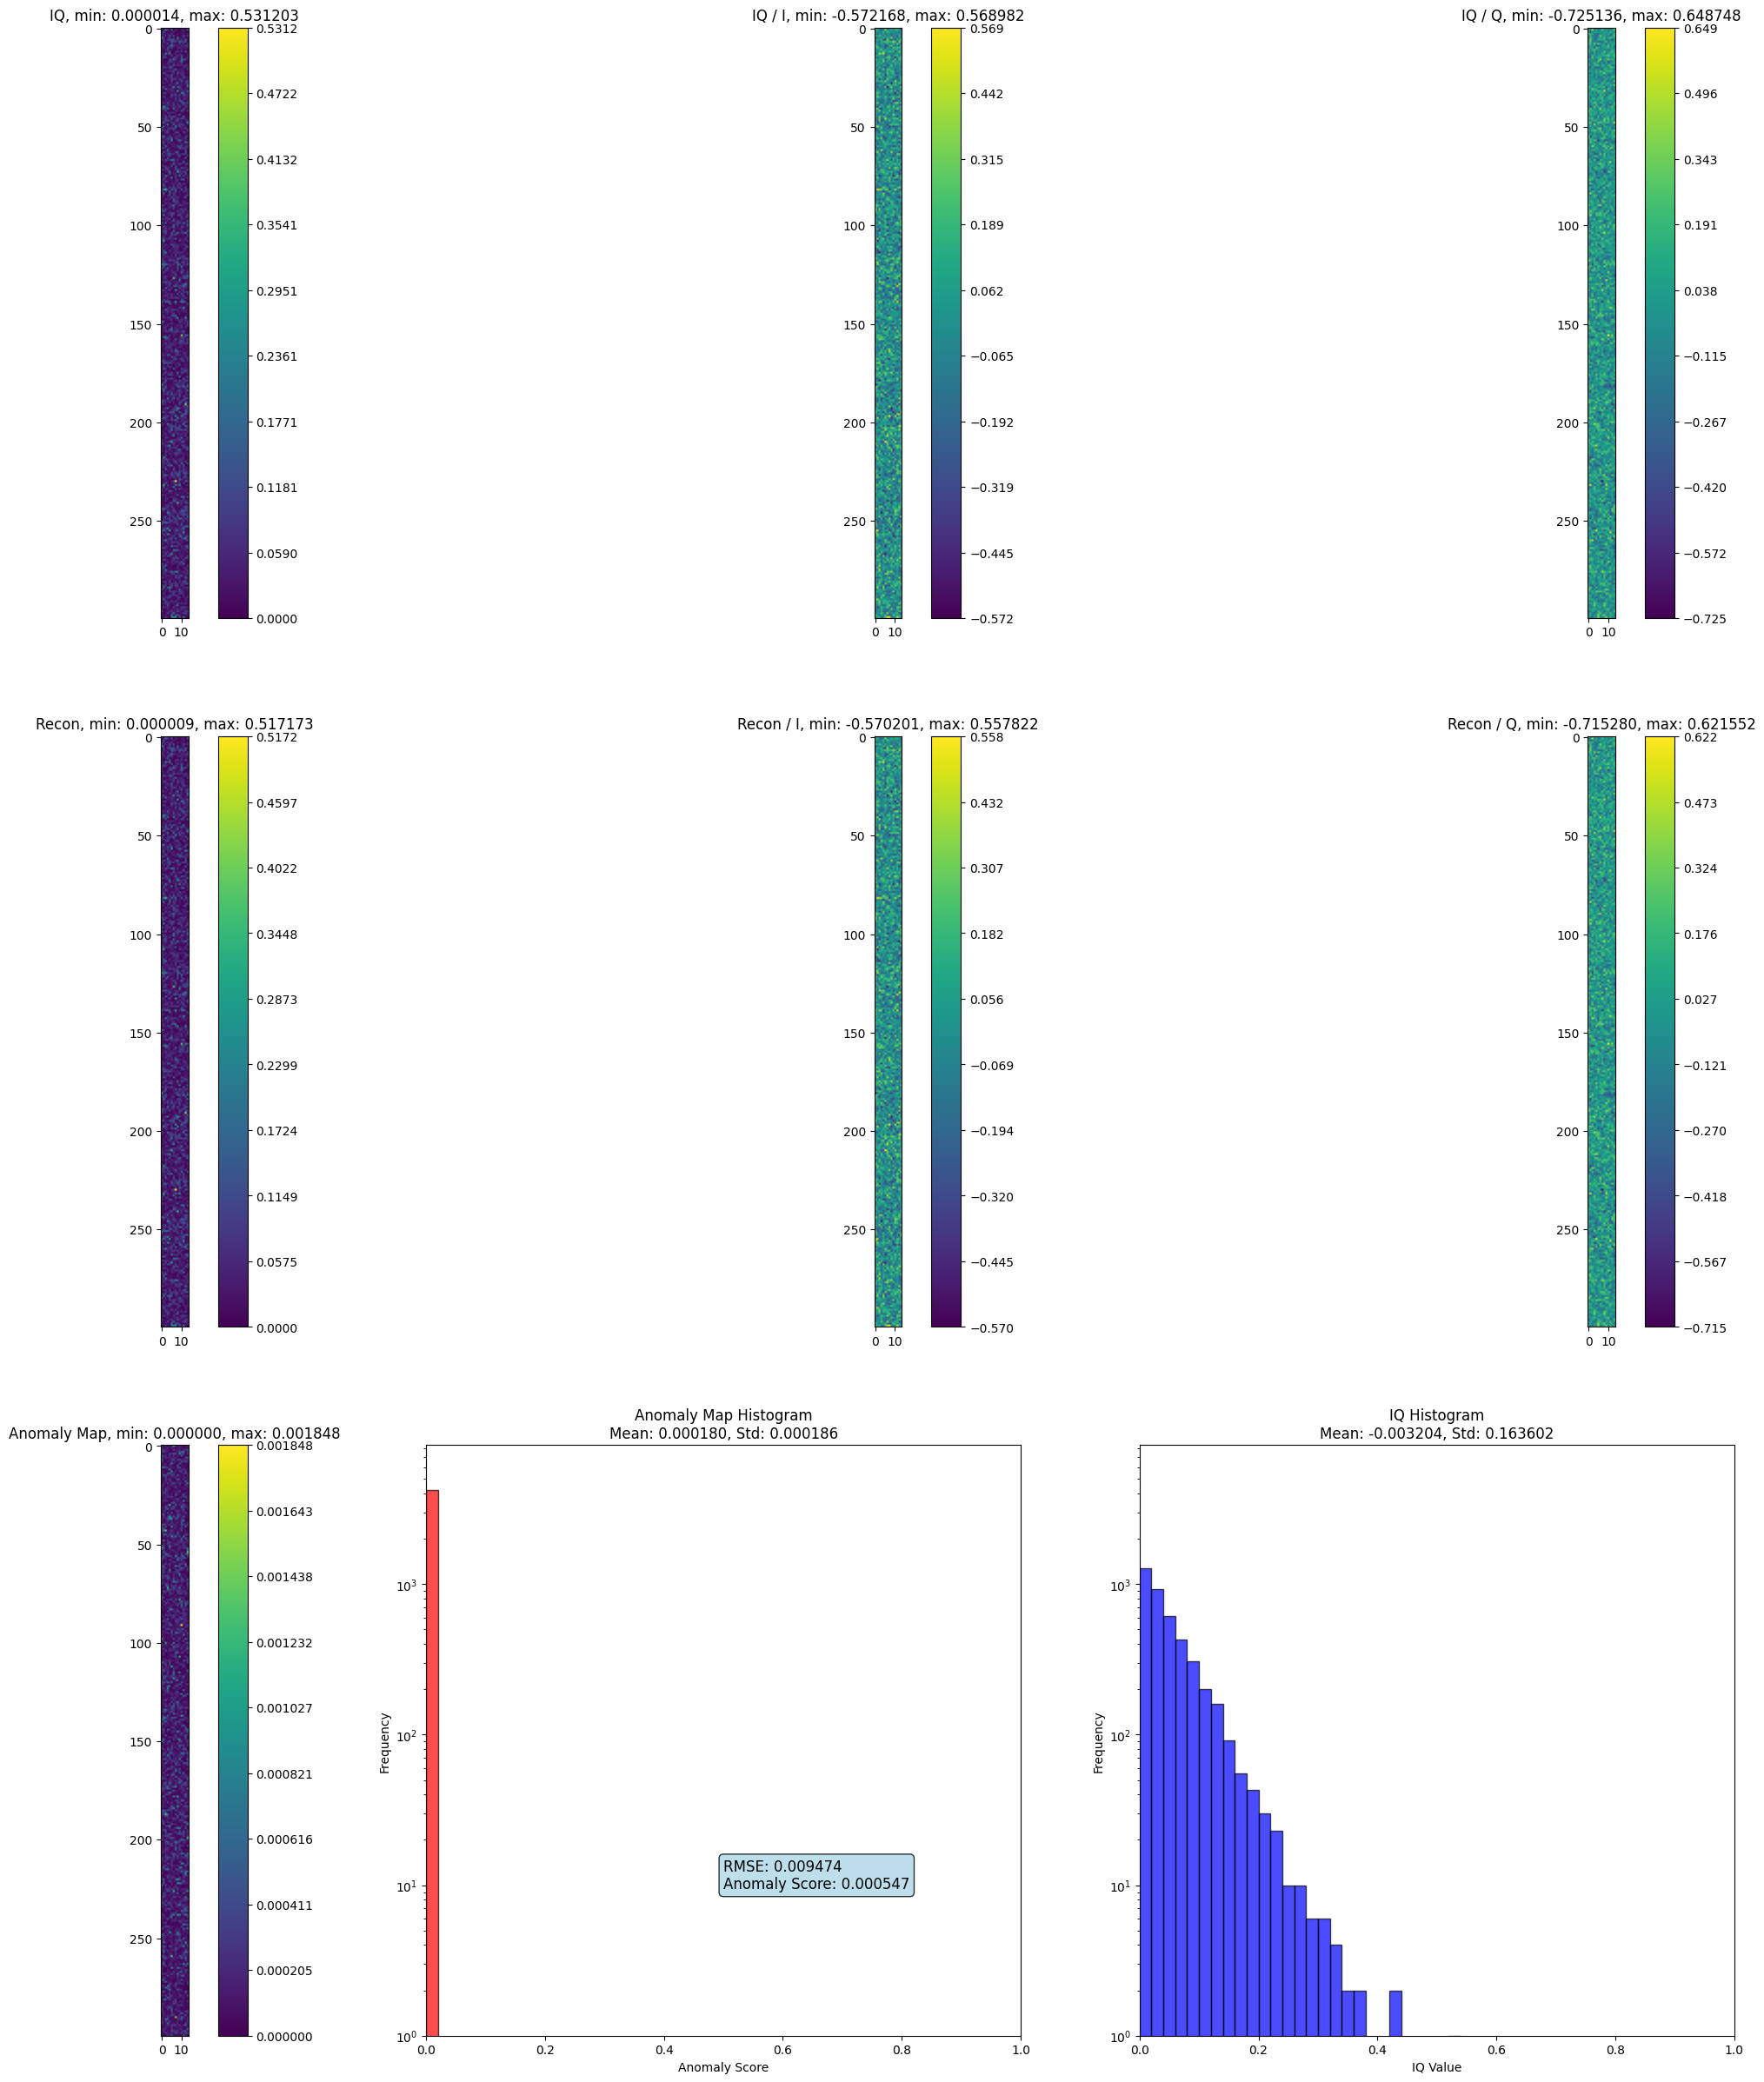

In [124]:
# Load and visualize a test sample
test_file_path = train_df.iloc[1]["file_path"]
test_AE(test_file_path, ae, device)

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.008375
loss:  tensor(0.5891, device='cuda:0')
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: -0.585511
Recon max: 0.548218
anomaly_map.shape: (300, 14)
(300, 14)


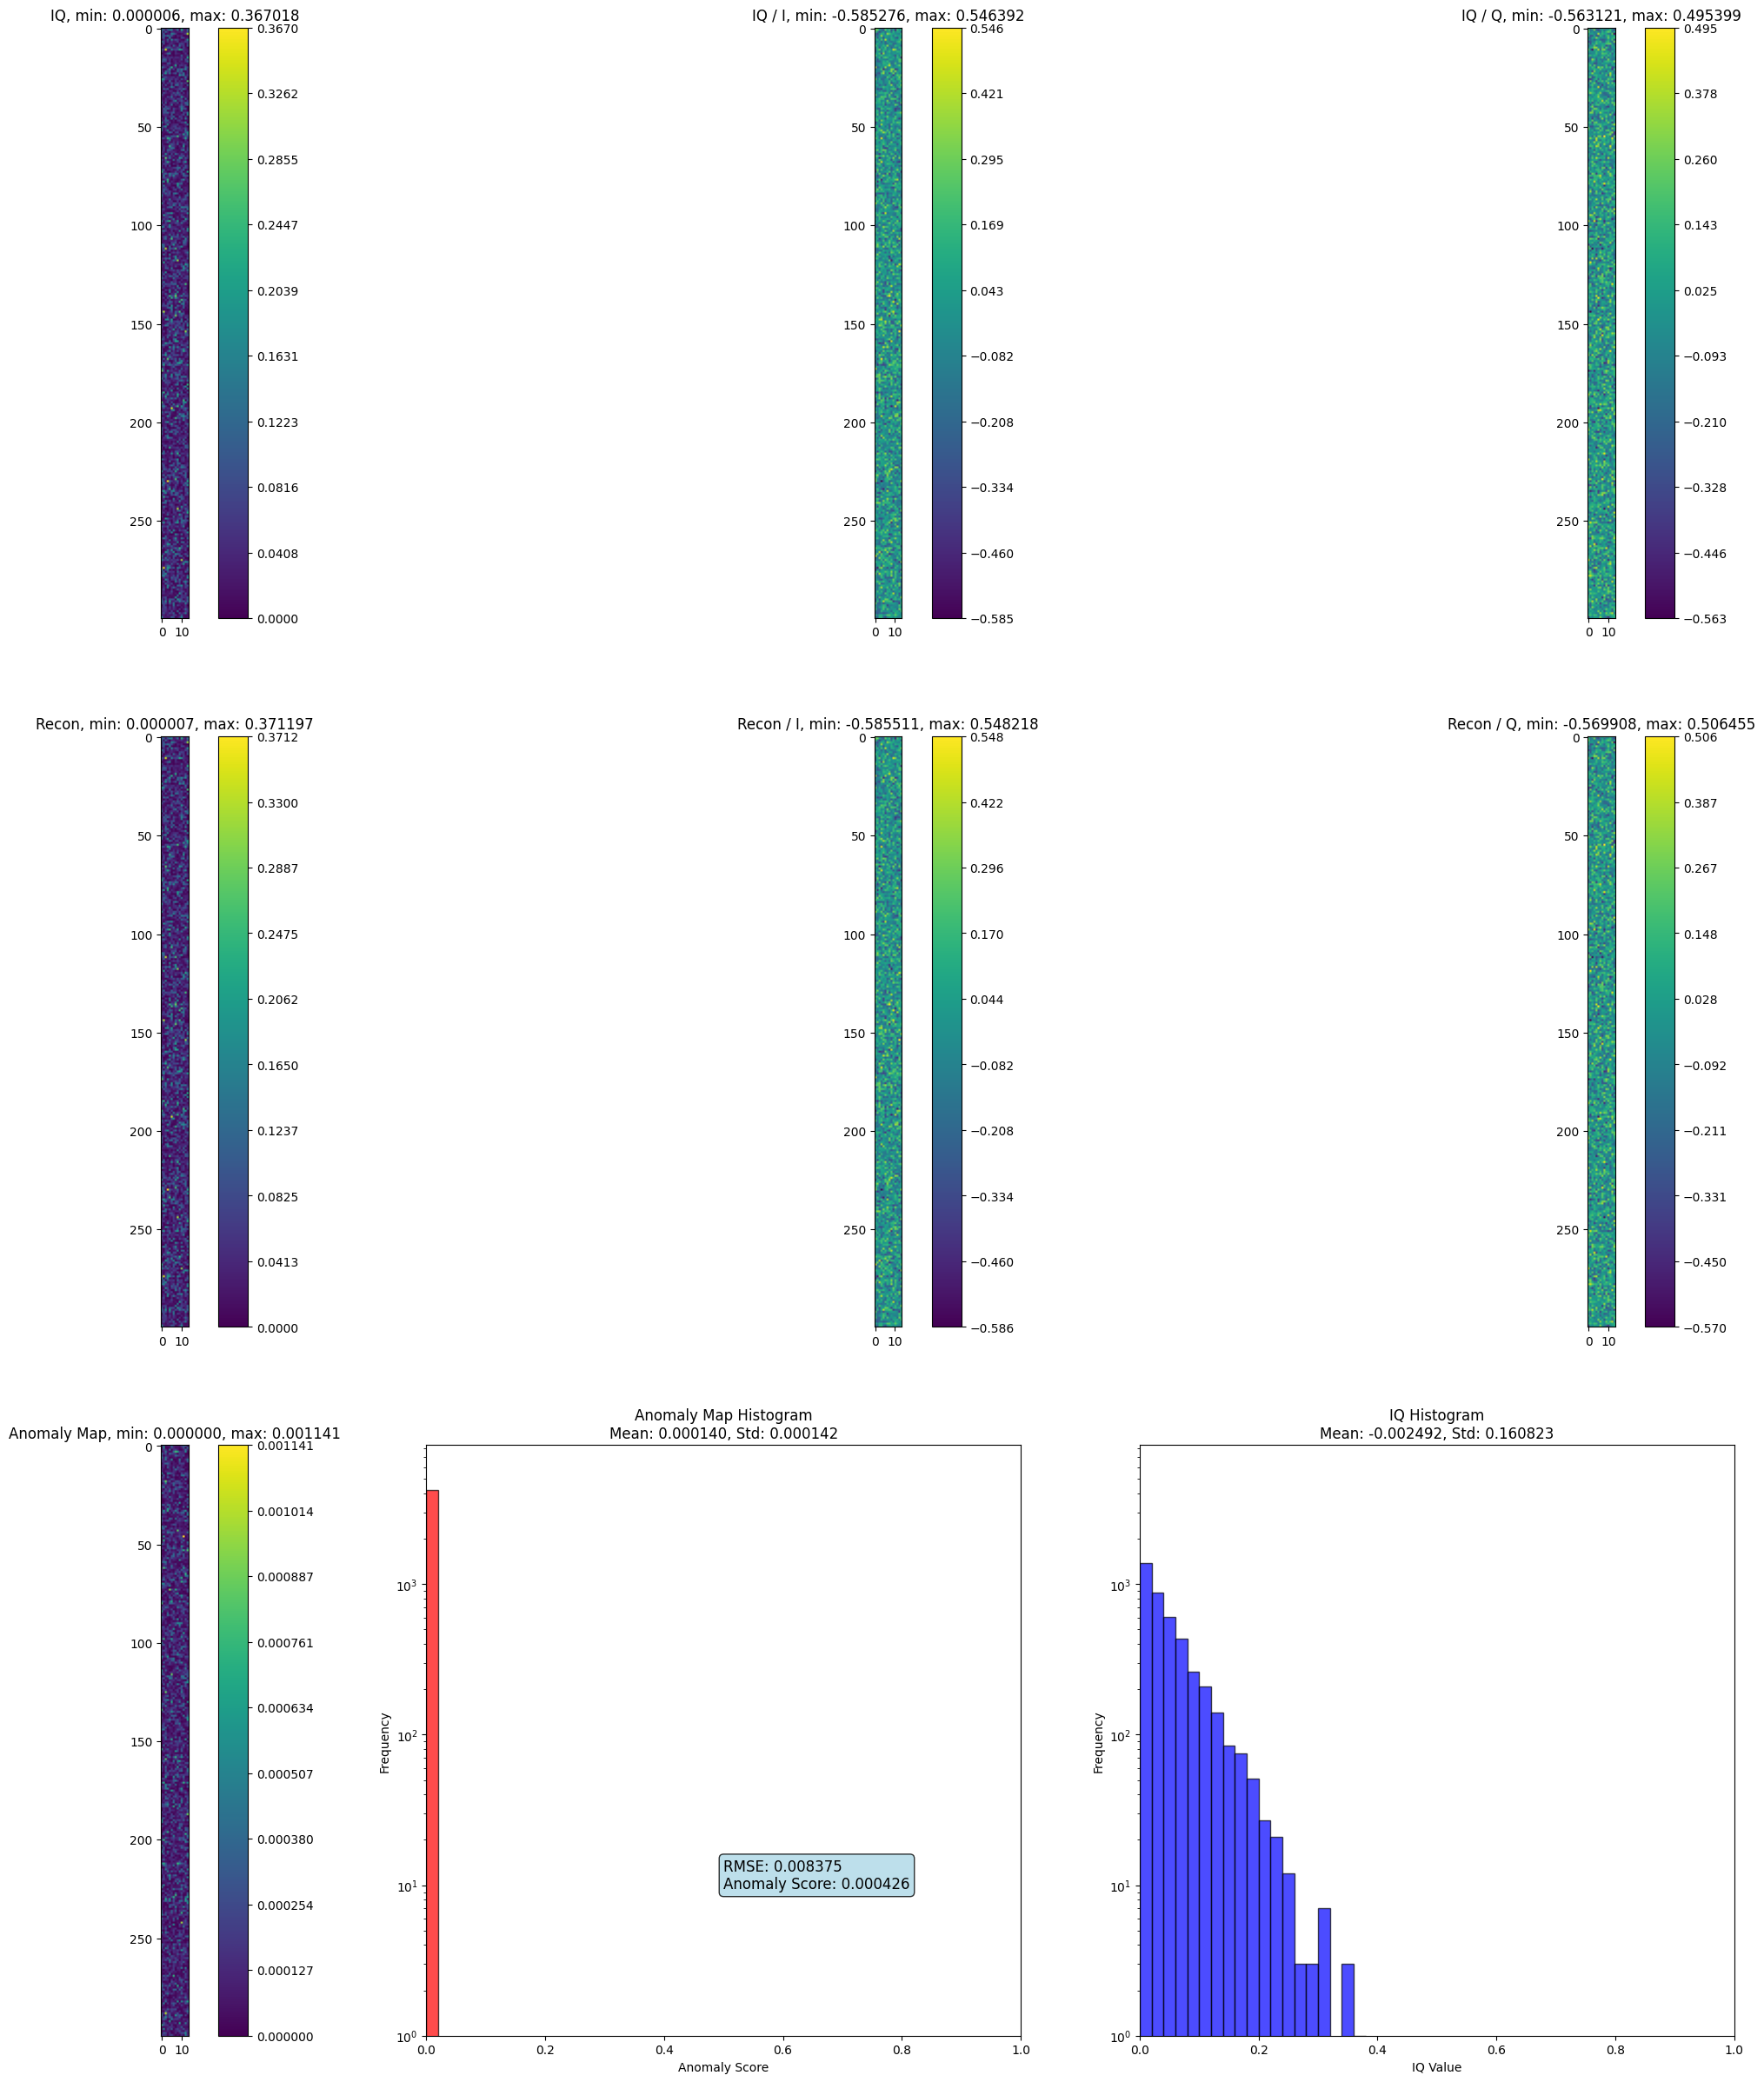

In [113]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/train/good/SNR_2_MCS_1_Slot_36_GridIdx_36_NoiseInterferenceGrid.mat"
test_AE(test_file_path, ae, device)

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.242506
loss:  tensor(493.9957, device='cuda:0')
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: -0.433131
Recon max: 0.458466
anomaly_map.shape: (300, 14)
(300, 14)


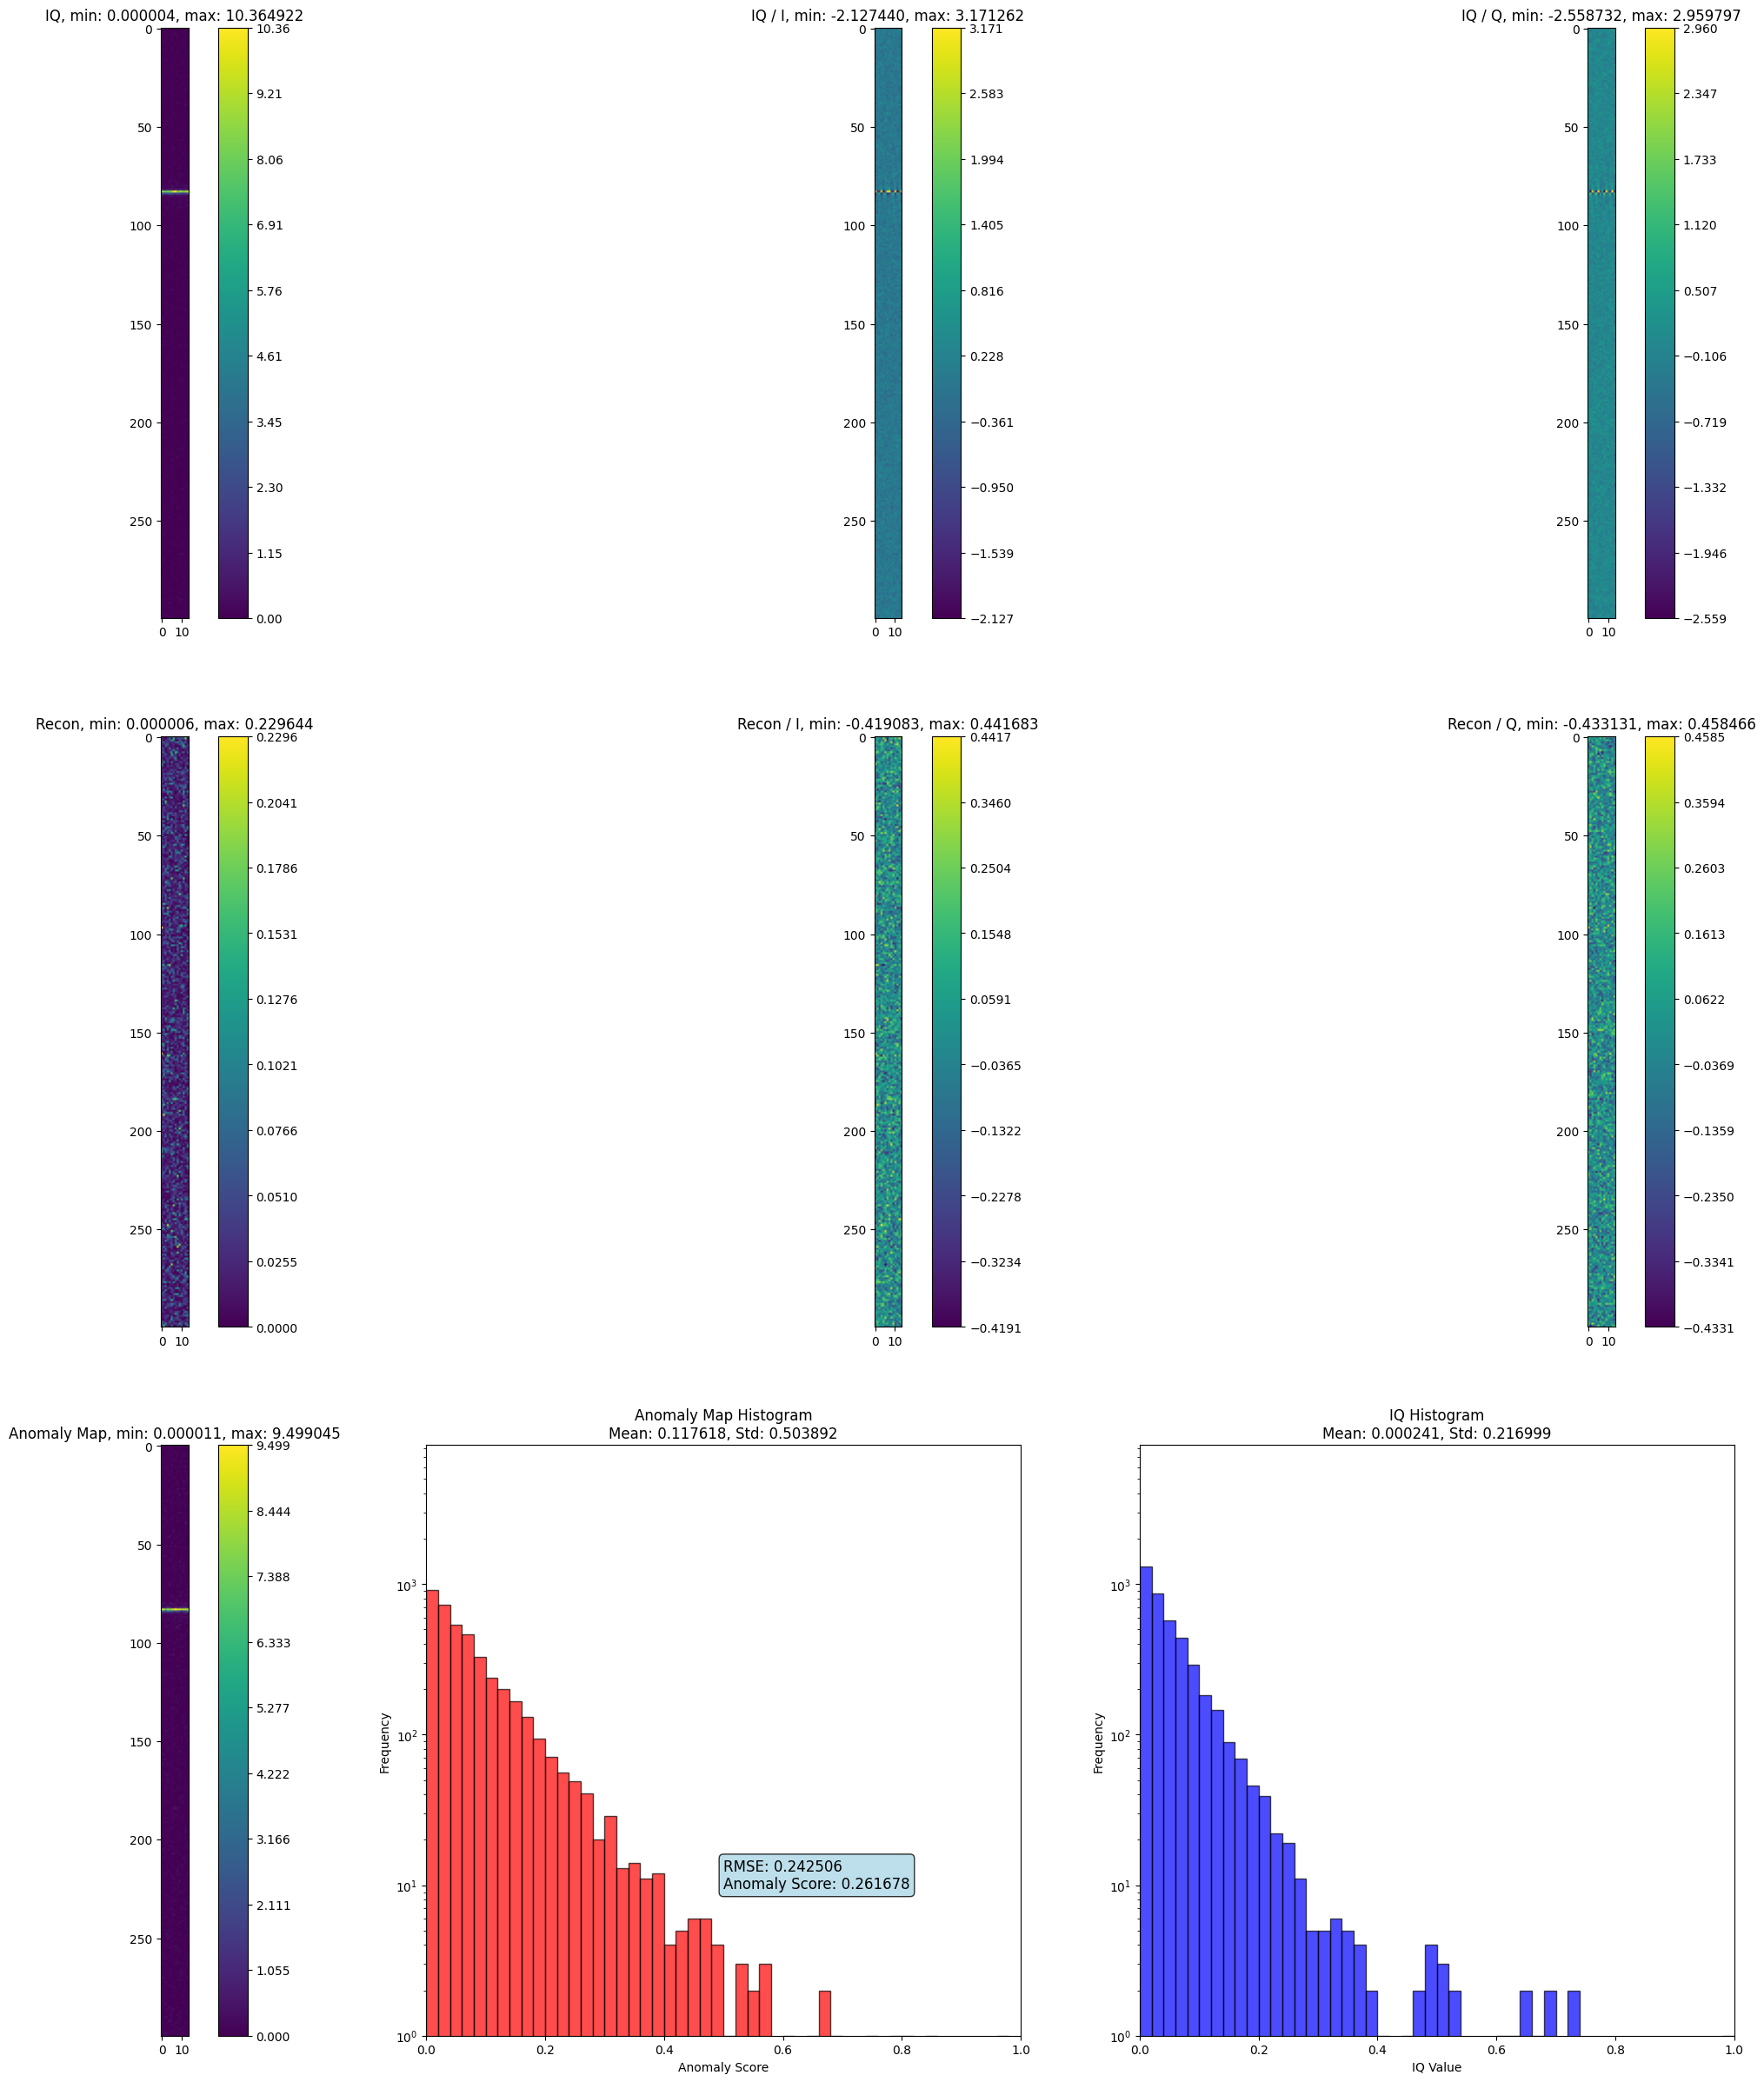

In [125]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/test/singletone/SNR_002_SIR_002_MCS_002_FRQ_-01000000_Slot_002_NoiseInterferenceGrid.mat"
test_AE(test_file_path, ae, device)

Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.188160
loss:  tensor(297.3955, device='cuda:0')
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: -0.381560
Recon max: 0.424665
anomaly_map.shape: (300, 14)
(300, 14)


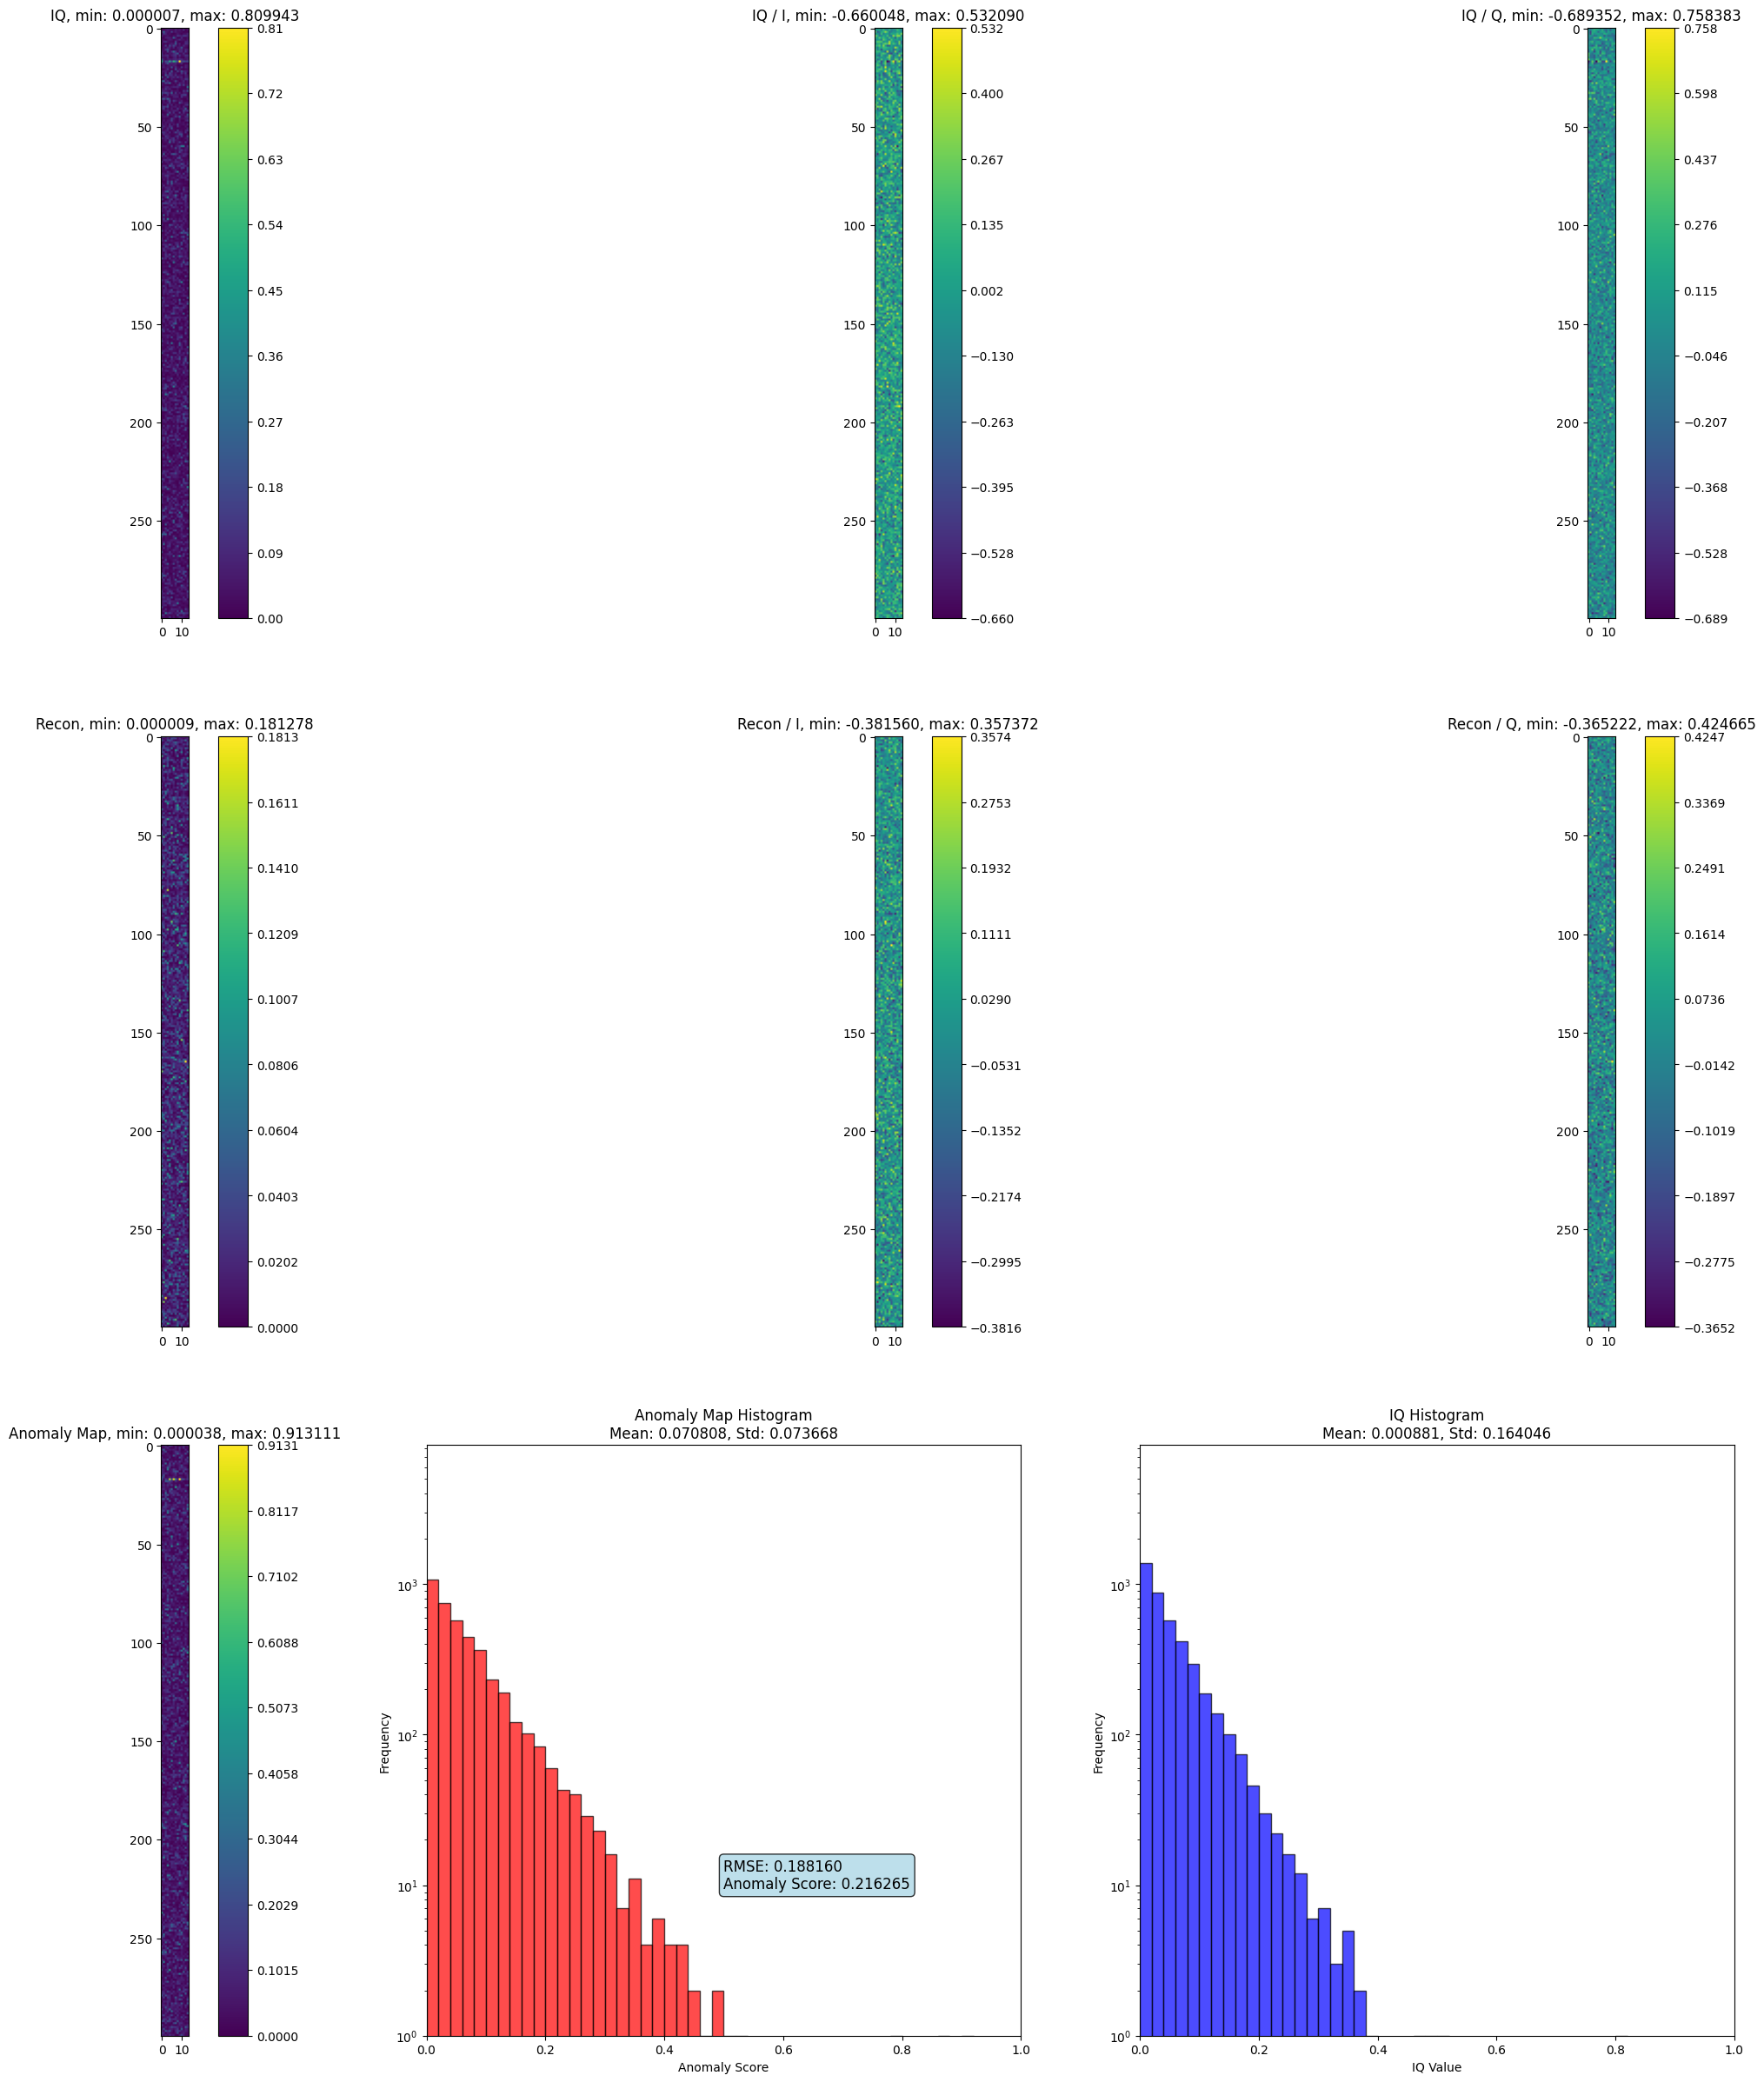

In [126]:
# Load and visualize a test sample
test_file_path = "/home/vantuan_ngo/anomalib-example/datasets/FccIQ/synthetic/test/singletone/SNR_002_SIR_018_MCS_008_FRQ_-02000000_Slot_030_NoiseInterferenceGrid.mat"
test_AE(test_file_path, ae, device)

In [129]:
import os
import pandas as pd
TEST_DF_FILE_PATH = os.path.join("../datasets/FccIQ/synthetic/test_df.csv")
print("TEST_DF_FILE_PATH: ", TEST_DF_FILE_PATH)
test_df = pd.read_csv(TEST_DF_FILE_PATH)
print(f'test_df.shape: {test_df.shape}')
print(test_df.head())

test_df = test_df[test_df["SNR"] == 2]
# train_df = train_df.sample(n=10, random_state=42)

tests, ground_truths = load_test_dataset(test_df)
print(f'tests.shape: {tests.shape}')
print(f'ground_truths.shape: {ground_truths.shape}')

test_loader = DataLoader(list(zip(tests, ground_truths)), batch_size=1, shuffle=False)
i, (data, label) = next(enumerate(test_loader))
print(i)
print(data.shape)
print(label.shape)

# reconstructed, mu, logvar, offset = ae(data)
# print(f'reconstructed.shape: {reconstructed.shape}')
# print(f'mu.shape: {mu.shape}')
# print(f'logvar.shape: {logvar.shape}')
# print(f'offset.shape: {offset.shape}')

TEST_DF_FILE_PATH:  ../datasets/FccIQ/synthetic/test_df.csv
test_df.shape: (23374, 7)
   SNR  SIR  MCS  FRQ  Slot  \
0    1   -1    1   -1     3   
1    1   -1    1   -1    11   
2    1   -1    1   -1    12   
3    1   -1    1   -1    17   
4    1   -1    1   -1    21   

                                           file_path ground_truth_file_path  
0  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                    NaN  
1  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                    NaN  
2  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                    NaN  
3  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                    NaN  
4  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                    NaN  
tests.shape: torch.Size([13458, 2, 300, 14])
ground_truths.shape: torch.Size([13458, 1])
0
torch.Size([1, 2, 300, 14])
torch.Size([1, 1])


SNR                                                                       2
SIR                                                                      -1
MCS                                                                       1
FRQ                                                                      -1
Slot                                                                     10
file_path                 /home/vantuan_ngo/anomalib-example/FccIQ/../da...
ground_truth_file_path                                                  NaN
Name: 79, dtype: object
Test data shape: (300, 14, 3)
Normalized data shape: (2, 300, 14)
Tensor shape: torch.Size([1, 2, 300, 14])
Reconstruction MSE: 0.187597
loss:  tensor(295.6172, device='cuda:0')
Original shape: torch.Size([1, 2, 300, 14])
Reconstructed shape: torch.Size([1, 2, 300, 14])
Recon min: -0.413130
Recon max: 0.441699
anomaly_map.shape: (300, 14)
(300, 14)


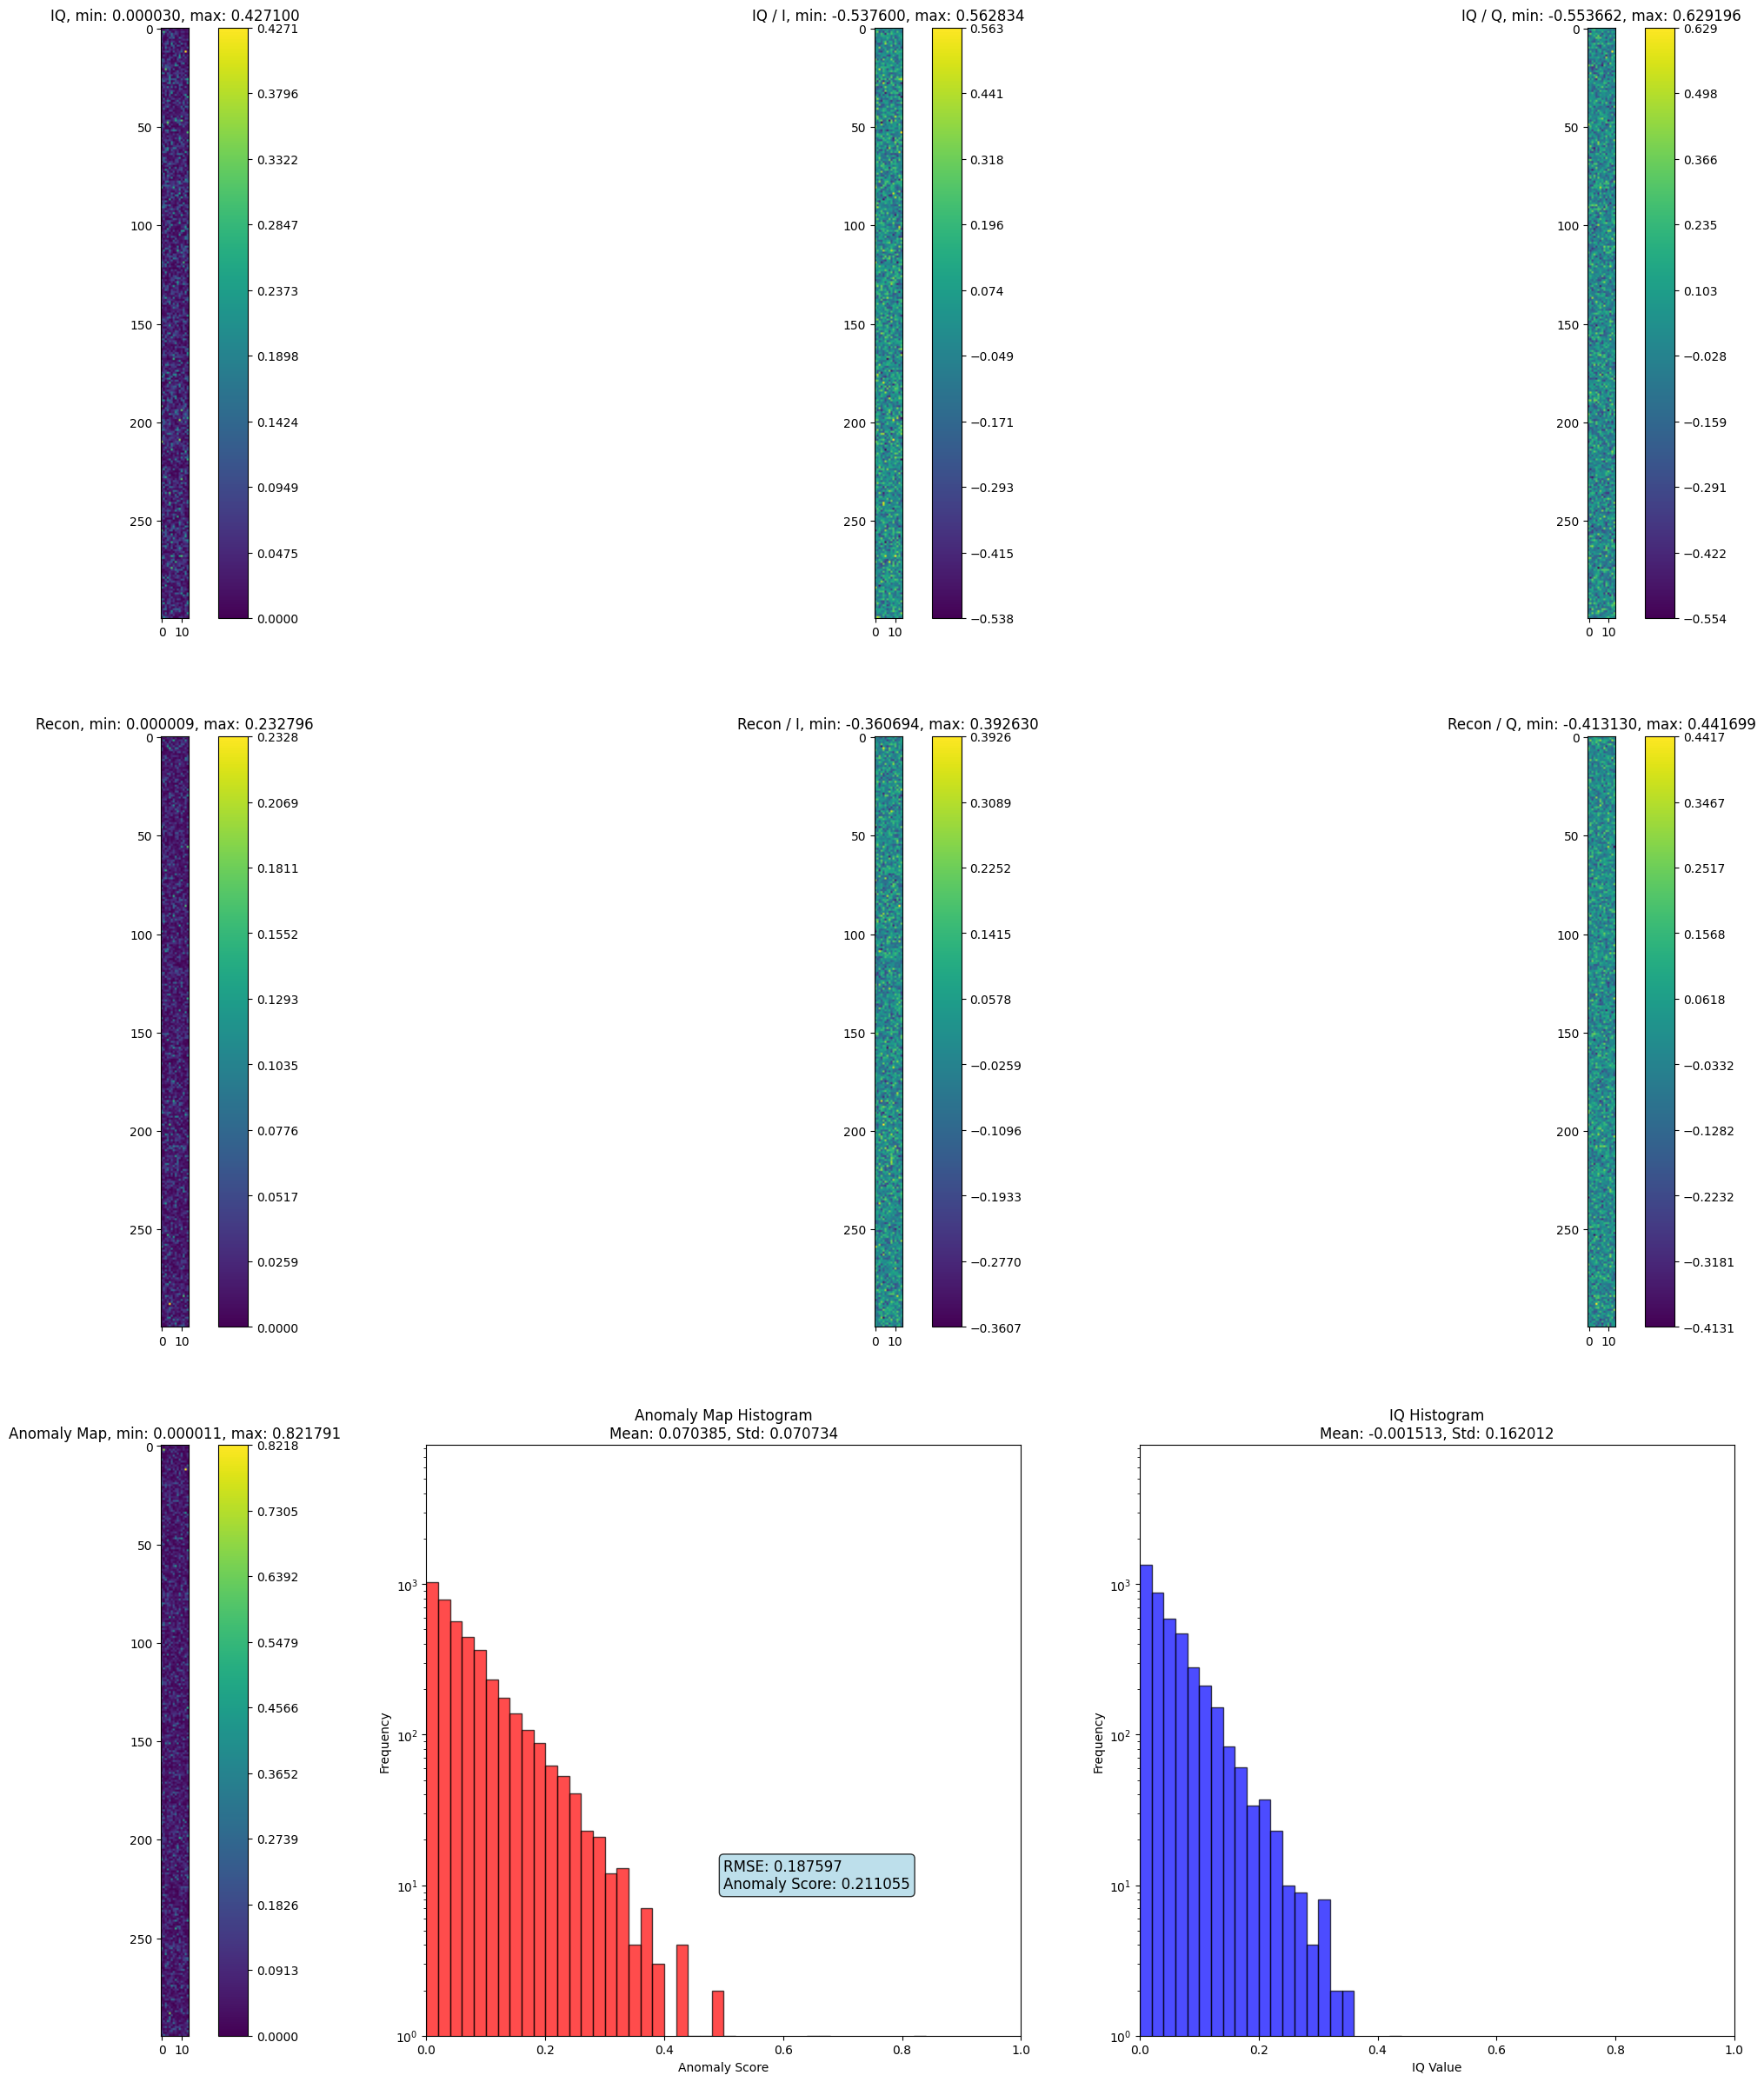

In [131]:
# Load and visualize a test sample
test = test_df.iloc[1]
print(test)
test_file_path = test["file_path"]
test_AE(test_file_path, ae, device)

In [ ]:
from sklearn.metrics import f1_score

# Test Autoencoder
print("Testing Autoencoder...")

# Test reconstruction on all test data
with torch.no_grad():

    total_anomaly_loss = 0
    total_samples = 0
    total_f1 = 0
    
    print("Testing reconstruction on all test data...")
    
    for batch_idx, (test_batch, label_batch) in enumerate(test_loader):
        # Move to device
        test_batch = test_batch.to(device)
        label_batch = label_batch.to(device)

        # Forward pass
        reconstructed, mu, logvar, offset = ae(test_batch)
        anomaly_map = generate_anomaly_map(test_batch, reconstructed)
        # print(anomaly_map.shape)
        # print(label_batch.shape)

        # Calculate reconstruction loss
        anomaly_loss = torch.nn.functional.mse_loss(anomaly_map, label_batch)
        total_anomaly_loss += anomaly_loss.item() * test_batch.size(0)
        total_samples += test_batch.size(0)
        
        # Calculate F1 score
        # Convert predictions to binary (threshold at 0.5)
        anomaly_map = anomaly_map.detach().cpu().numpy()
        print(anomaly_map.shape)
        dynamic_threshold = np.percentile(anomaly_map, 99, axis=(2, 3)).squeeze()
        print(dynamic_threshold.shape)
        anomaly_threshold = np.max([[threshold]*anomaly_map.shape[0], dynamic_threshold], axis=0).reshape(anomaly_map.shape[0], 1, 1, 1)
        print(anomaly_threshold.shape)
        # print(f"Anomaly threshold: {anomaly_threshold}")
        anomaly_bin = (anomaly_map > anomaly_threshold)

        label_batch = label_batch.detach().cpu().numpy()
        print(label_batch.shape)
        label_bin = (label_batch > 10*label_batch.mean())
        print("label_bin.shape ", label_bin.shape)
        print("anomaly_bin.shape ", anomaly_bin.shape)
        f1 = f1_score(label_bin.flatten(), anomaly_bin.flatten())
        print("f1 ", f1)
        total_f1 += f1 * test_batch.size(0)

        if batch_idx == 0:
            print(f"First batch - Original shape: {test_batch.shape}")
            print(f"First batch - Reconstructed shape: {reconstructed.shape}")
            print(f"First batch - Latent space shape: mu={mu.shape}, logvar={logvar.shape}")
            print(f"First batch - Reconstruction Loss: {anomaly_loss.item():.6f}")

        if (batch_idx + 1) % 10 == 0:
            print(f"Processed {batch_idx + 1} batches...")
    
    avg_anomaly_loss = total_anomaly_loss / total_samples
    avg_f1 = total_f1 / total_samples
    print(f"\nTesting completed!")
    print(f"Total samples tested: {total_samples}")
    print(f"Average Anomaly Loss: {avg_anomaly_loss:.6f}")
    print(f"Average F1 score: {avg_f1:.6f}")

print("Autoencoder testing completed!")


In [ ]:
from sklearn.metrics import f1_score

# Test Autoencoder
print("Testing Autoencoder...")

# Test reconstruction on all test data
with torch.no_grad():

    total_anomaly_loss = 0
    total_samples = 0
    total_f1 = 0
    
    print("Testing reconstruction on all test data...")
    
    for batch_idx, (test_batch, label_batch) in enumerate(tests):
        # Move to device
        test_batch = test_batch.to(device)
        label_batch = label_batch.to(device)

        # Forward pass
        reconstructed, mu, logvar, offset = ae(test_batch)
        anomaly_map = generate_anomaly_map(test_batch, reconstructed)

        # Calculate reconstruction loss
        anomaly_loss = torch.nn.functional.mse_loss(anomaly_map, label_batch)
        total_anomaly_loss += anomaly_loss.item() * test_batch.size(0)
        total_samples += test_batch.size(0)
        
        # Calculate F1 score
        # Convert predictions to binary (threshold at 0.5)
        anomaly_map = anomaly_map.detach().cpu().numpy()
        dynamic_threshold = np.percentile(anomaly_map, 99, axis=(2, 3)).squeeze()
        anomaly_threshold = np.max([[threshold]*anomaly_map.shape[0], dynamic_threshold], axis=0).reshape(anomaly_map.shape[0], 1, 1, 1)
        anomaly_bin = (anomaly_map > anomaly_threshold)
        label_batch = label_batch.detach().cpu().numpy()
        label_bin = (label_batch > 20*label_batch.mean())
        f1 = f1_score(label_bin.flatten(), anomaly_bin.flatten())
        total_f1 += f1 * test_batch.size(0)

        if batch_idx == 0:
            print(f"First batch - Original shape: {test_batch.shape}")
            print(f"First batch - Reconstructed shape: {reconstructed.shape}")
            print(f"First batch - Latent space shape: mu={mu.shape}, logvar={logvar.shape}")
            print(f"First batch - Reconstruction Loss: {anomaly_loss.item():.6f}")
        
        if (batch_idx + 1) % 20 == 0:
            print(f"Processed {batch_idx + 1} batches...")
            print("f1 ", f1)
            
            plt.figure(figsize=(24, 8))
            plt.subplot(1,6,1)
            plt.imshow(test_batch[0].cpu().numpy()[0], cmap='viridis')
            print("test_batch[0].shape", test_batch[0].shape)
            plt.title('Original Input')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()
            
            plt.subplot(1,6,2)
            plt.imshow(anomaly_map[0][0], cmap='viridis')
            print("anomaly_map[0].shape", anomaly_map[0].shape)
            plt.title('Anomaly Map')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()
            
            plt.subplot(1,6,3)
            plt.imshow(label_batch[0][0], cmap='viridis')
            print("label_batch[0].shape", label_batch[0].shape)
            plt.title('Label Map')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()

            plt.subplot(1,6,4)
            plt.imshow(anomaly_bin[0][0], cmap='viridis')
            plt.title('AB')
            print("anomaly_bin[0].shape", anomaly_bin[0].shape)
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()
            
            plt.subplot(1,6,5)
            plt.imshow(label_bin[0][0], cmap='viridis')
            plt.title('LB')
            print("label_bin[0].shape", label_bin[0].shape)
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()
            
            plt.subplot(1,6,6)
            diff_bin = (anomaly_bin[0][0] ^ label_bin[0][0])
            plt.imshow(diff_bin, cmap='gray')
            plt.title('AB ^ LB')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.colorbar()

            # plt.tight_layout()

            plt.show()
            break
    
    avg_anomaly_loss = total_anomaly_loss / total_samples
    avg_f1 = total_f1 / total_samples
    print(f"\nTesting completed!")
    print(f"Total samples tested: {total_samples}")
    print(f"Average Anomaly Loss: {avg_anomaly_loss:.6f}")
    print(f"Average F1 score: {avg_f1:.6f}")

print("Autoencoder testing completed!")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Image
from io import BytesIO

# Initialize PDF
pdf_filename = "anomaly_maps.pdf"
pdf = SimpleDocTemplate(pdf_filename, pagesize=letter)
elements = []

for batch_idx, iqs in enumerate(train_loader):
    print(f"Processing batch {batch_idx}/{len(train_loader)}")
    print(iqs.shape)
    iqs = iqs.to(device)
    
    with torch.no_grad():
        recons, mu, logvar = ae(iqs)
        anomaly_maps = generate_anomaly_map(iqs, recons)
        
        print("Saving to file...")
        iqs = iqs.cpu().numpy()
        for i in range(iqs.shape[0]):
            iq = iqs[i]
            recon = recons[i].cpu().numpy()
            anomaly_map = anomaly_maps[i].cpu().numpy().squeeze()
            # print("iq.shape: ", iq.shape)
            # print("recon.shape: ", recon.shape)
            # print("anomaly_map.shape: ", anomaly_map.shape)
            
            # Create figure
            plt.figure(figsize=(10, 10))
            plt.subplot(1, 3, 1)
            plt.imshow(np.sum(iq**2, axis=0), cmap='viridis')
            plt.colorbar()
            plt.title('IQ')
            
            plt.subplot(1, 3, 2)
            plt.imshow(np.sum(recon**2, axis=0), cmap='viridis')
            plt.colorbar()
            plt.title('Recon')
            
            plt.subplot(1, 3, 3)
            plt.imshow(anomaly_map, cmap='gray')
            plt.colorbar()
            plt.title('Anomaly Map')
            
            # Save plot to BytesIO buffer
            bio = BytesIO()
            plt.savefig(bio, format='png', bbox_inches='tight')
            bio.seek(0)
            
            # Add to PDF
            plot_image = Image(bio, width=300, height=300)
            elements.append(plot_image)
            
            plt.close()
    #         break
    #     break
    # break

print("Building PDF")
pdf.build(elements)
print(f"Saved anomaly plots to ./{pdf_filename}")